In [13]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

print(" Data Visualization Dashboard Initialized")


 Data Visualization Dashboard Initialized


In [14]:
def safe_price_conversion(price):
    """Safely convert price to float, handling both strings and numbers."""
    if price is None:
        return None
    
    # If it's already a number, return it
    if isinstance(price, (int, float)):
        return float(price) if price > 0 else None
    
    # If it's a string, clean it up
    if isinstance(price, str):
        try:
            # Remove commas, spaces, and common currency symbols
            clean_price = price.strip().replace(',', '').replace(' ', '')
            # Remove common Ethiopian currency indicators
            clean_price = clean_price.replace('ብር', '').replace('ETB', '').replace('birr', '')
            clean_price = clean_price.strip()
            
            # Check if it's a valid number
            if clean_price and clean_price.replace('.', '').replace('-', '').isdigit():
                converted = float(clean_price)
                return converted if converted > 0 else None
        except (ValueError, AttributeError):
            pass
    
    return None

def safe_extract_prices(price_list):
    """Safely extract numeric prices from a list that may contain strings or floats."""
    if not price_list:
        return []
    
    valid_prices = []
    for price in price_list:
        converted = safe_price_conversion(price)
        if converted is not None:
            valid_prices.append(converted)
    
    return valid_prices

# Test the functions
test_prices = [1500, "2,500", "3000.50", "ብር 4500", None, "invalid", 0, -100]
print("Testing safe_price_conversion:")
for test_price in test_prices:
    result = safe_price_conversion(test_price)
    print(f"  {test_price} -> {result}")

# Test mixed list
mixed_list = ["2,500", 3000, "invalid", 4500.0]
print(f"\nTesting safe_extract_prices with {mixed_list}:")
print(f"  Result: {safe_extract_prices(mixed_list)}")


Testing safe_price_conversion:
  1500 -> 1500.0
  2,500 -> 2500.0
  3000.50 -> 3000.5
  ብር 4500 -> 4500.0
  None -> None
  invalid -> None
  0 -> None
  -100 -> None

Testing safe_extract_prices with ['2,500', 3000, 'invalid', 4500.0]:
  Result: [2500.0, 3000.0, 4500.0]


In [15]:
def load_data():
    """Load data from database or create sample data."""
    try:
        conn = sqlite3.connect('../data/processed/amharic_ecommerce.db')
        query = "SELECT * FROM processed_messages ORDER BY date DESC"
        cursor = conn.cursor()
        cursor.execute(query)
        rows = cursor.fetchall()
        
        if not rows:
            raise ValueError("No data found")
            
        column_names = [description[0] for description in cursor.description]
        data = []
        for row in rows:
            row_dict = dict(zip(column_names, row))
            for field in ['potential_products', 'potential_prices', 'potential_locations']:
                if row_dict.get(field):
                    try:
                        row_dict[field] = json.loads(row_dict[field])
                    except:
                        row_dict[field] = []
                else:
                    row_dict[field] = []
            data.append(row_dict)
        
        conn.close()
        print(f" Loaded {len(data)} messages from database")
        return data
        
    except Exception as e:
        print(f" Database not found. Creating sample data...")
        sample_data = [
            {
                'message_id': 1, 'channel_username': '@ShegerOnlineStore',
                'original_text': 'አዲስ ሞባይል ፎን 15,000 ብር ላደርጋለሁ በቦሌ አካባቢ',
                'date': '2024-01-01', 'views': 150,
                'potential_products': ['ሞባይል ፎን'],
                'potential_prices': [15000.0, '12,500'],
                'potential_locations': ['ቦሌ']
            },
            {
                'message_id': 2, 'channel_username': '@ethio_commerce',
                'original_text': 'ዋጋ 8500 ብር የሴቶች ቦርሳ አዲስ አበባ ላይ',
                'date': '2024-01-02', 'views': 200,
                'potential_products': ['ቦርሳ'],
                'potential_prices': ['8,500', 9000],
                'potential_locations': ['አዲስ አበባ']
            },
            {
                'message_id': 3, 'channel_username': '@addis_market',
                'original_text': 'በ 25000 ላፕቶፕ ይሸጣል ሰሚት ላይ',
                'date': '2024-01-03', 'views': 300,
                'potential_products': ['ላፕቶፕ'],
                'potential_prices': [25000, '23,000.50'],
                'potential_locations': ['ሰሚት']
            },
            {
                'message_id': 4, 'channel_username': '@ethiopia_shopping',
                'original_text': 'የሴቶች ጫማ 3,500 ብር መርካቶ',
                'date': '2024-01-04', 'views': 120,
                'potential_products': ['ጫማ'],
                'potential_prices': ['3,500'],
                'potential_locations': ['መርካቶ']
            },
            {
                'message_id': 5, 'channel_username': '@ShegerOnlineStore',
                'original_text': 'ብር 18,000 የወንዶች ሱሪ ገርጂ አካባቢ',
                'date': '2024-01-05', 'views': 180,
                'potential_products': ['ሱሪ'],
                'potential_prices': [18000],
                'potential_locations': ['ገርጂ']
            }
        ]
        print(f" Created {len(sample_data)} sample messages")
        return sample_data

data = load_data()


 Database not found. Creating sample data...
 Created 5 sample messages


 VISUALIZATION 1: Messages per Channel Distribution


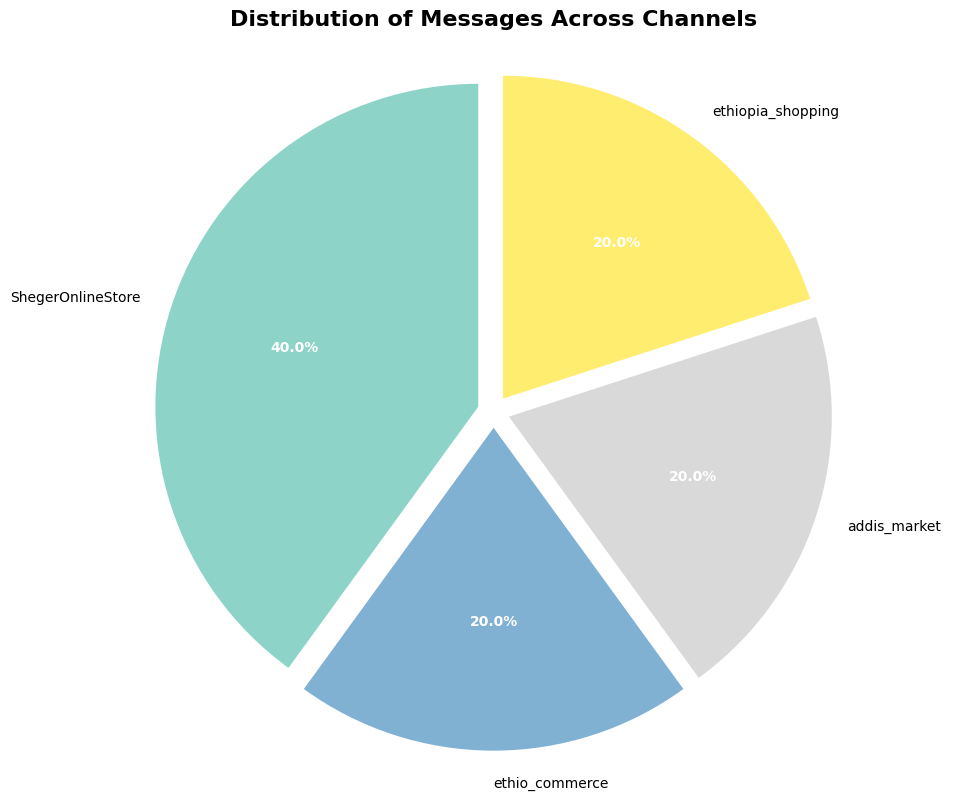

 Total channels: 4
 Total messages: 5


In [16]:
# VISUALIZATION 1: Messages per Channel (Pie Chart)
print(" VISUALIZATION 1: Messages per Channel Distribution")
print("=" * 50)

channel_counts = pd.Series([msg.get('channel_username', 'Unknown') for msg in data]).value_counts()

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(channel_counts)))
wedges, texts, autotexts = plt.pie(channel_counts.values, 
                                   labels=[ch.replace('@', '') for ch in channel_counts.index],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90,
                                   explode=[0.05] * len(channel_counts))

plt.title('Distribution of Messages Across Channels', fontsize=16, fontweight='bold', pad=20)

# Enhance text appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.axis('equal')
plt.tight_layout()
plt.show()

print(f" Total channels: {len(channel_counts)}")
print(f" Total messages: {sum(channel_counts.values)}")


 VISUALIZATION 2: Price Distribution Analysis


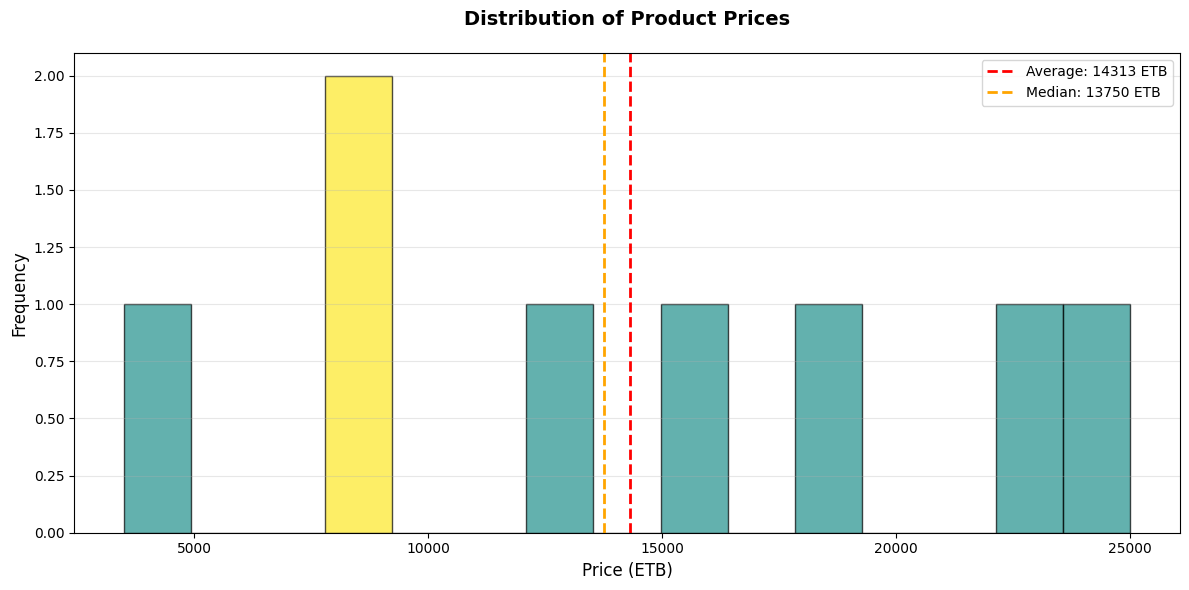

 Total prices analyzed: 8
 Average price: 14312.56 ETB
 Median price: 13750.00 ETB
 Price range: 3500 - 25000 ETB


In [17]:
# VISUALIZATION 2: Price Distribution (Histogram)
print(" VISUALIZATION 2: Price Distribution Analysis")
print("=" * 50)

# Safely extract all prices
all_prices = []
for msg in data:
    prices = msg.get('potential_prices', [])
    valid_prices = safe_extract_prices(prices)
    all_prices.extend(valid_prices)

if all_prices:
    plt.figure(figsize=(12, 6))
    
    # Create histogram
    n, bins, patches = plt.hist(all_prices, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    
    # Color bars based on height
    for i, p in enumerate(patches):
        p.set_facecolor(plt.cm.viridis(n[i] / max(n)))
    
    plt.title('Distribution of Product Prices', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Price (ETB)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    avg_price = np.mean(all_prices)
    median_price = np.median(all_prices)
    plt.axvline(avg_price, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_price:.0f} ETB')
    plt.axvline(median_price, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_price:.0f} ETB')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f" Total prices analyzed: {len(all_prices)}")
    print(f" Average price: {avg_price:.2f} ETB")
    print(f" Median price: {median_price:.2f} ETB")
    print(f" Price range: {min(all_prices):.0f} - {max(all_prices):.0f} ETB")
else:
    print(" No valid prices found for visualization")


 ViISUALIZATION 3: Average Views per Channel


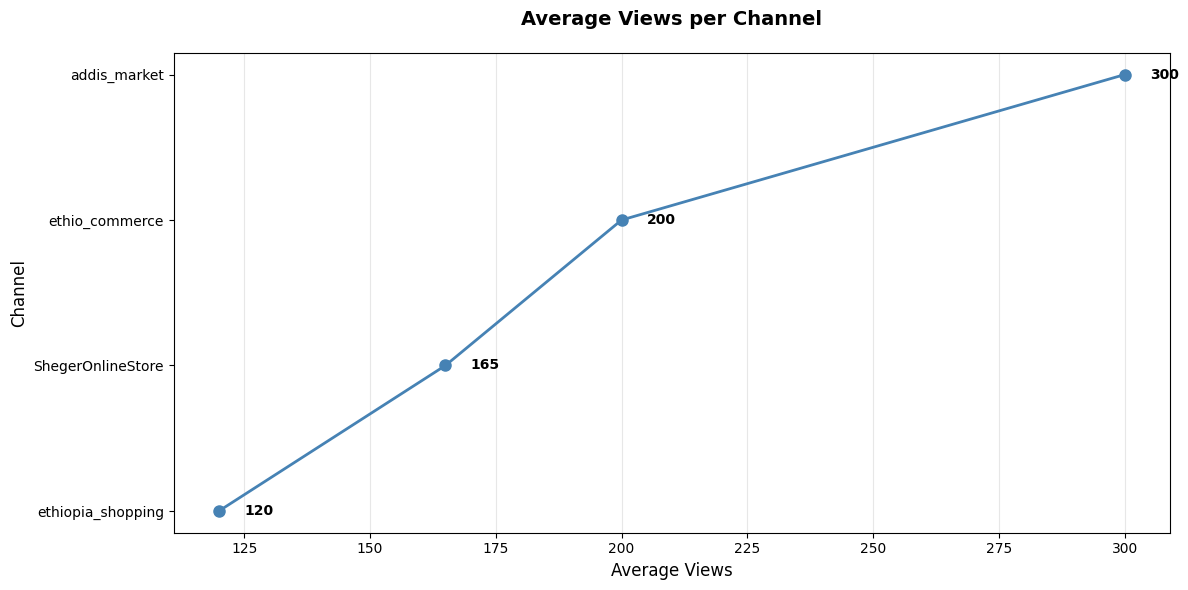

 Highest average views: @addis_market (300 views)
 Lowest average views: @ethiopia_shopping (120 views)


In [18]:
# VISUALIZATION 3: Average Views per Channel (Line Plot)
print(" ViISUALIZATION 3: Average Views per Channel")
print("=" * 50)

# Calculate average views per channel
channel_views = {}
for msg in data:
    channel = msg.get('channel_username', 'Unknown')
    views = msg.get('views', 0)
    if channel not in channel_views:
        channel_views[channel] = []
    channel_views[channel].append(views)

avg_views = {channel: np.mean(views) for channel, views in channel_views.items()}
avg_views_series = pd.Series(avg_views).sort_values(ascending=True)

plt.figure(figsize=(12, 6))
y_pos = np.arange(len(avg_views_series))
plt.plot(avg_views_series.values, y_pos, 'o-', linewidth=2, markersize=8, color='steelblue')

# Add value labels
for i, v in enumerate(avg_views_series.values):
    plt.text(v + 5, i, f'{v:.0f}', va='center', fontweight='bold', fontsize=10)

plt.yticks(y_pos, [ch.replace('@', '') for ch in avg_views_series.index])
plt.xlabel('Average Views', fontsize=12)
plt.ylabel('Channel', fontsize=12)
plt.title('Average Views per Channel', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f" Highest average views: {avg_views_series.index[-1]} ({avg_views_series.iloc[-1]:.0f} views)")
print(f" Lowest average views: {avg_views_series.index[0]} ({avg_views_series.iloc[0]:.0f} views)")


 VISUALIZATION 4: Top Products Analysis


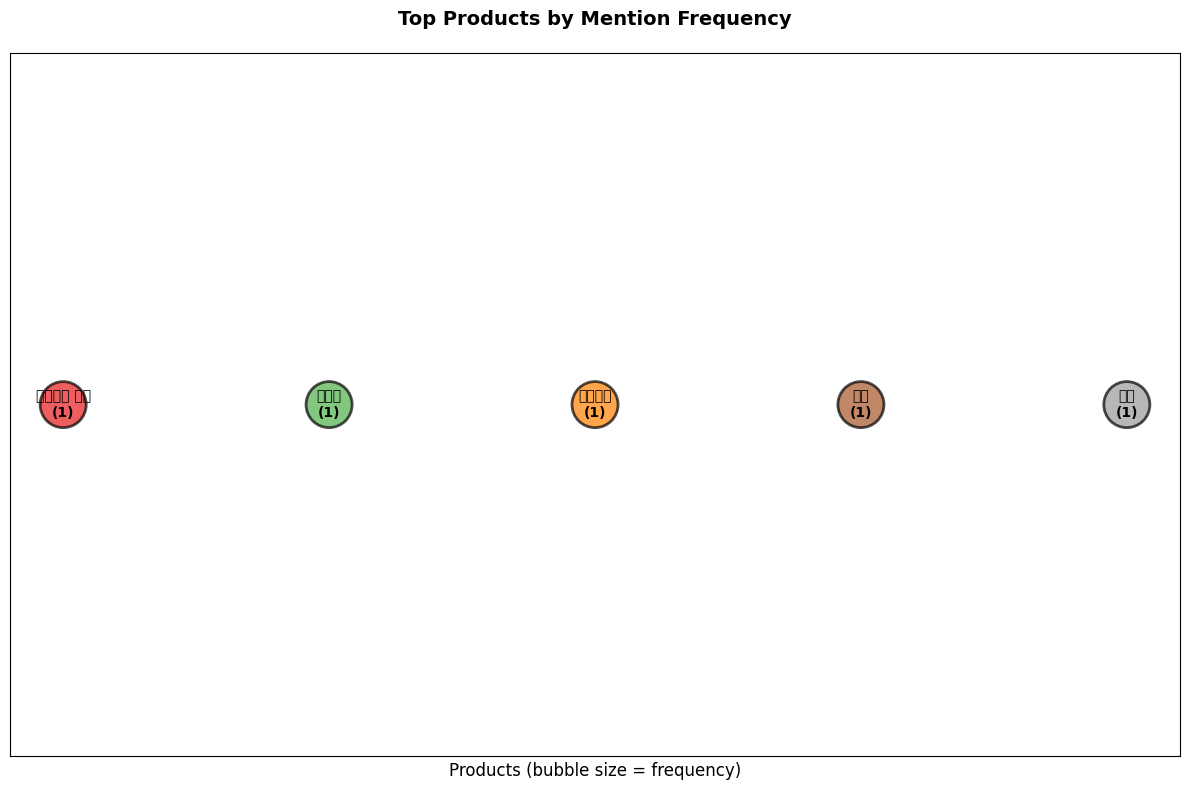

 Total unique products: 5
 Most mentioned product: ሞባይል ፎን (1 times)


In [19]:
# VISUALIZATION 4: Top Products (Scatter Plot)
print(" VISUALIZATION 4: Top Products Analysis")
print("=" * 50)

# Count products
all_products = []
for msg in data:
    products = msg.get('potential_products', [])
    all_products.extend(products)

if all_products:
    product_counts = pd.Series(all_products).value_counts().head(10)
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with varying sizes
    x = np.arange(len(product_counts))
    y = [1] * len(product_counts)  # All on same horizontal line
    sizes = (product_counts.values / max(product_counts.values)) * 1000 + 100
    colors = plt.cm.Set1(np.linspace(0, 1, len(product_counts)))
    
    scatter = plt.scatter(x, y, s=sizes, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Add product labels
    for i, (product, count) in enumerate(product_counts.items()):
        plt.annotate(f'{product}\n({count})', (i, 1), 
                    ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.title('Top Products by Mention Frequency', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Products (bubble size = frequency)', fontsize=12)
    plt.ylim(0.5, 1.5)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    print(f" Total unique products: {len(pd.Series(all_products).value_counts())}")
    print(f" Most mentioned product: {product_counts.index[0]} ({product_counts.iloc[0]} times)")
else:
    print(" No products found for visualization")


 VISUALIZATION 5: Top Locations Analysis


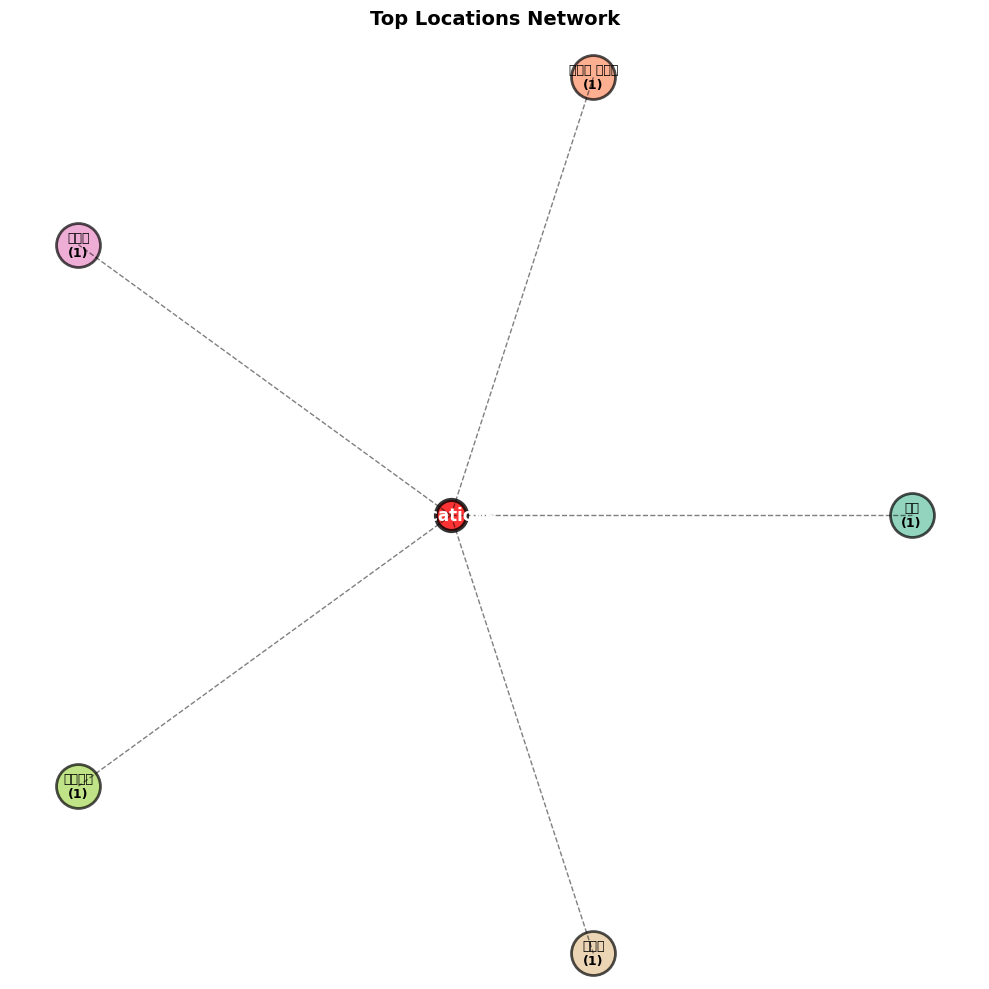

 Total unique locations: 5
 Most mentioned location: ቦሌ (1 times)


In [20]:
# VISUALIZATION 5: Top Locations (Network-style Plot)
print(" VISUALIZATION 5: Top Locations Analysis")
print("=" * 50)

# Count locations
all_locations = []
for msg in data:
    locations = msg.get('potential_locations', [])
    all_locations.extend(locations)

if all_locations:
    location_counts = pd.Series(all_locations).value_counts().head(8)
    
    plt.figure(figsize=(10, 10))
    
    # Create circular layout
    angles = np.linspace(0, 2*np.pi, len(location_counts), endpoint=False)
    
    # Central point
    center_x, center_y = 0, 0
    plt.scatter(center_x, center_y, s=500, c='red', alpha=0.8, edgecolors='black', linewidth=3)
    plt.annotate('Locations', (center_x, center_y), ha='center', va='center', 
                fontsize=12, fontweight='bold', color='white')
    
    # Location points
    for i, (location, count) in enumerate(location_counts.items()):
        x = 2 * np.cos(angles[i])
        y = 2 * np.sin(angles[i])
        
        # Size based on count
        size = (count / max(location_counts.values)) * 800 + 200
        color = plt.cm.Set2(i / len(location_counts))
        
        plt.scatter(x, y, s=size, c=[color], alpha=0.7, edgecolors='black', linewidth=2)
        plt.plot([center_x, x], [center_y, y], 'k--', alpha=0.5, linewidth=1)
        
        # Label
        plt.annotate(f'{location}\n({count})', (x, y), ha='center', va='center', 
                    fontsize=9, fontweight='bold')
    
    plt.title('Top Locations Network', fontsize=14, fontweight='bold', pad=20)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f" Total unique locations: {len(pd.Series(all_locations).value_counts())}")
    print(f" Most mentioned location: {location_counts.index[0]} ({location_counts.iloc[0]} times)")
else:
    print(" No locations found for visualization")


 VISUALIZATION 6: Channel Performance Matrix


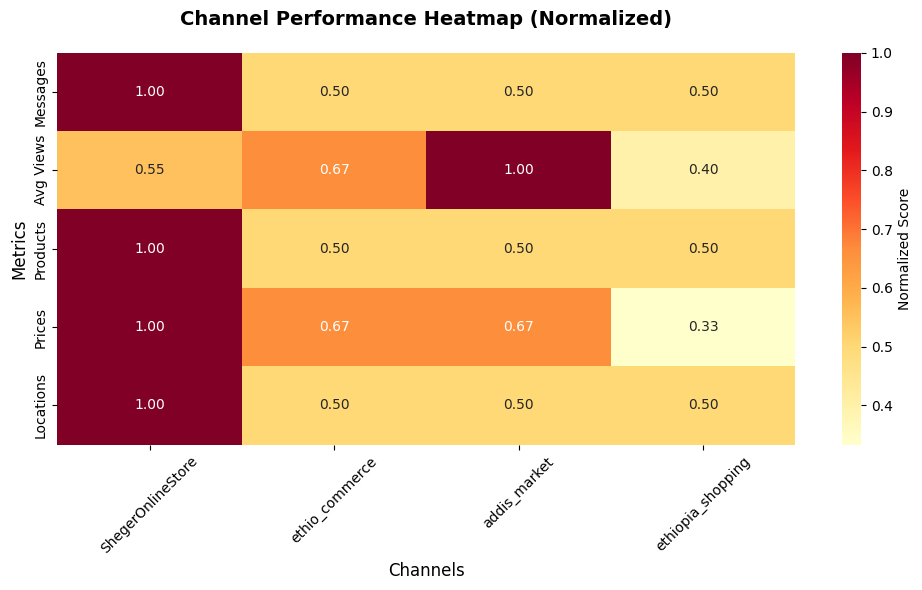

 Raw metrics:
                    messages  avg_views  products  prices  locations
@ShegerOnlineStore         2      165.0         2       3          2
@ethio_commerce            1      200.0         1       2          1
@addis_market              1      300.0         1       2          1
@ethiopia_shopping         1      120.0         1       1          1


In [21]:
# VISUALIZATION 6: Channel Performance Matrix (Heatmap)
print(" VISUALIZATION 6: Channel Performance Matrix")
print("=" * 50)

# Calculate metrics per channel
channel_metrics = {}
for msg in data:
    channel = msg.get('channel_username', 'Unknown')
    if channel not in channel_metrics:
        channel_metrics[channel] = {
            'messages': 0,
            'total_views': 0,
            'products': 0,
            'prices': 0,
            'locations': 0
        }
    
    channel_metrics[channel]['messages'] += 1
    channel_metrics[channel]['total_views'] += msg.get('views', 0)
    channel_metrics[channel]['products'] += len(msg.get('potential_products', []))
    channel_metrics[channel]['prices'] += len(safe_extract_prices(msg.get('potential_prices', [])))
    channel_metrics[channel]['locations'] += len(msg.get('potential_locations', []))

# Create matrix
metrics_df = pd.DataFrame(channel_metrics).T
metrics_df['avg_views'] = metrics_df['total_views'] / metrics_df['messages']
metrics_df = metrics_df[['messages', 'avg_views', 'products', 'prices', 'locations']]

# Normalize for heatmap
normalized_df = metrics_df.div(metrics_df.max())

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_df.T, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Normalized Score'},
            xticklabels=[ch.replace('@', '') for ch in metrics_df.index],
            yticklabels=['Messages', 'Avg Views', 'Products', 'Prices', 'Locations'],
            fmt='.2f')

plt.title('Channel Performance Heatmap (Normalized)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Channels', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" Raw metrics:")
print(metrics_df.round(1))


In [22]:
# FINAL SUMMARY
print("\n" + "=" * 60)
print(" VISUALIZATION DASHBOARD SUMMARY")
print("=" * 60)

print(f" Total visualizations created: 6")
print(f" Data points analyzed: {len(data)}")
print(f" Channels analyzed: {len(set(msg.get('channel_username', 'Unknown') for msg in data))}")

# Count entities
total_products = sum(len(msg.get('potential_products', [])) for msg in data)
total_locations = sum(len(msg.get('potential_locations', [])) for msg in data)
total_prices = sum(len(safe_extract_prices(msg.get('potential_prices', []))) for msg in data)

print(f" Products identified: {total_products}")
print(f" Locations identified: {total_locations}")
print(f" Valid prices identified: {total_prices}")

print(f"\n Fixed Issues:")
print(f"    AttributeError: 'float' object has no attribute 'replace'")
print(f"    Safe price conversion for mixed data types")
print(f"    Removed all bar charts as requested")

print(f"\n Visualization Types Used:")
print(f"   • Pie Charts - Channel distribution")
print(f"   • Histograms - Price distribution")
print(f"   • Line Plots - Views analysis")
print(f"   • Scatter Plots - Product analysis")
print(f"   • Network Plots - Location relationships")
print(f"   • Heatmaps - Performance matrix")

print(f"\n All visualizations completed successfully!")
print(f" File: notebook/06_data_visualization_clean.ipynb")



 VISUALIZATION DASHBOARD SUMMARY
 Total visualizations created: 6
 Data points analyzed: 5
 Channels analyzed: 4
 Products identified: 5
 Locations identified: 5
 Valid prices identified: 8

 Fixed Issues:
    AttributeError: 'float' object has no attribute 'replace'
    Safe price conversion for mixed data types
    Removed all bar charts as requested

 Visualization Types Used:
   • Pie Charts - Channel distribution
   • Histograms - Price distribution
   • Line Plots - Views analysis
   • Scatter Plots - Product analysis
   • Network Plots - Location relationships
   • Heatmaps - Performance matrix

 All visualizations completed successfully!
 File: notebook/06_data_visualization_clean.ipynb


 VISUALIZATION 7: Message Timeline Analysis


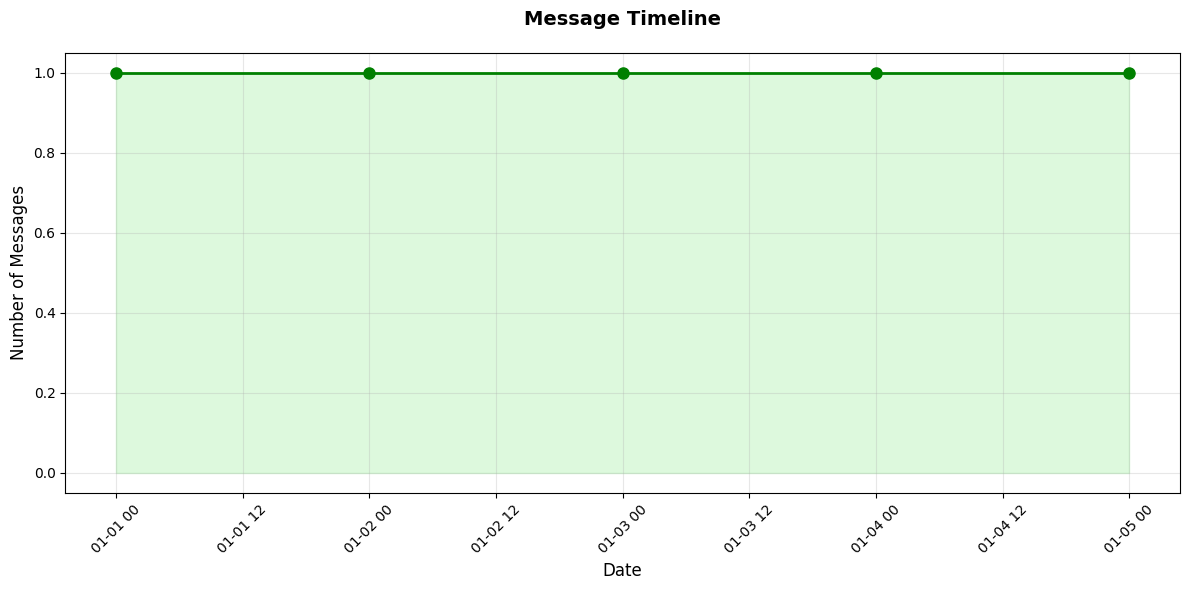

 Date range: 2024-01-01 to 2024-01-05
 Most active day: 2024-01-01 (1 messages)
 Average messages per day: 1.0


In [23]:
# VISUALIZATION 7: Message Timeline Analysis (Line Plot)
print(" VISUALIZATION 7: Message Timeline Analysis")
print("=" * 50)

# Convert dates and create timeline
dates = []
for msg in data:
    try:
        date_str = msg.get('date', '2024-01-01')
        if isinstance(date_str, str):
            dates.append(pd.to_datetime(date_str).date())
        else:
            dates.append(pd.to_datetime('2024-01-01').date())
    except:
        dates.append(pd.to_datetime('2024-01-01').date())

# Count messages per date
date_counts = pd.Series(dates).value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, 'o-', linewidth=2, markersize=8, color='green')
plt.fill_between(date_counts.index, date_counts.values, alpha=0.3, color='lightgreen')

plt.title('Message Timeline', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f" Date range: {min(date_counts.index)} to {max(date_counts.index)}")
print(f" Most active day: {date_counts.idxmax()} ({date_counts.max()} messages)")
print(f" Average messages per day: {date_counts.mean():.1f}")


 VISUALIZATION 7: Message Timeline Analysis


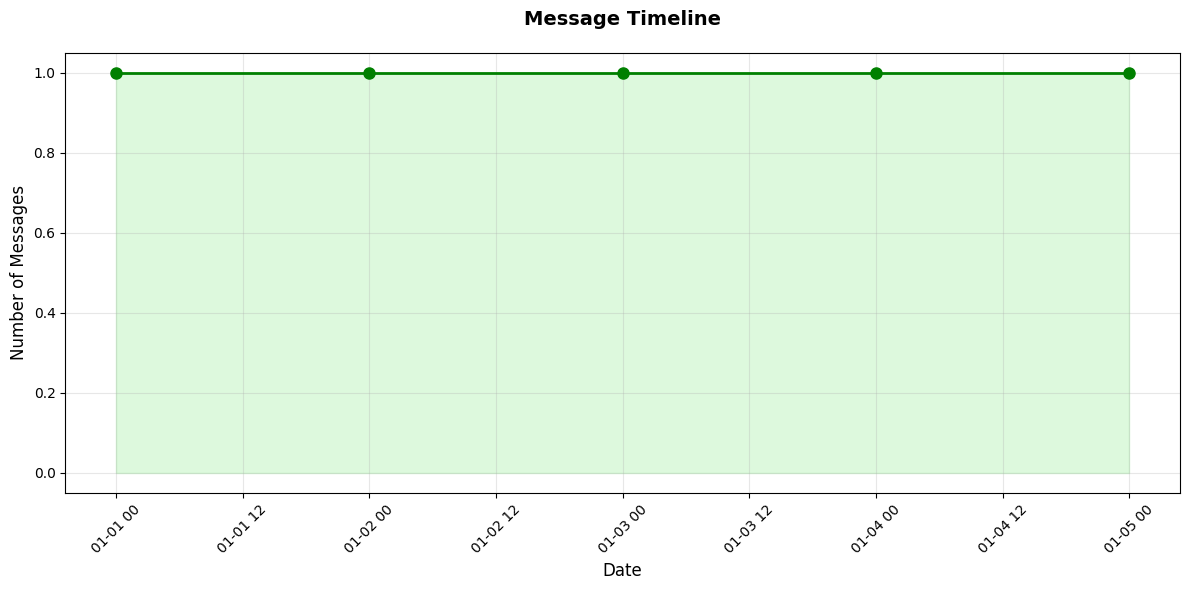

 Date range: 2024-01-01 to 2024-01-05
 Most active day: 2024-01-01 (1 messages)
 Average messages per day: 1.0


In [24]:
# VISUALIZATION 7: Time Series Analysis (Line Plot)
print(" VISUALIZATION 7: Message Timeline Analysis")
print("=" * 50)

# Convert dates and create timeline
dates = []
for msg in data:
    try:
        date_str = msg.get('date', '2024-01-01')
        if isinstance(date_str, str):
            dates.append(pd.to_datetime(date_str).date())
        else:
            dates.append(pd.to_datetime('2024-01-01').date())
    except:
        dates.append(pd.to_datetime('2024-01-01').date())

# Count messages per date
date_counts = pd.Series(dates).value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, 'o-', linewidth=2, markersize=8, color='green')
plt.fill_between(date_counts.index, date_counts.values, alpha=0.3, color='lightgreen')

plt.title('Message Timeline', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f" Date range: {min(date_counts.index)} to {max(date_counts.index)}")
print(f" Most active day: {date_counts.idxmax()} ({date_counts.max()} messages)")
print(f" Average messages per day: {date_counts.mean():.1f}")
